In [15]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [16]:
max_degree: int = 20
n_train, n_test = 100, 100
true_w: np.ndarray = np.zeros(max_degree)
true_w[0: 4] = np.array([5, 1.2, -3.4, 5.6])

In [17]:
features: np.ndarray = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features: np.ndarray = np.power(features, np.arange(max_degree).reshape(1, -1)) # 幂
for i in range(0, max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # 泛化的阶乘
labels: np.ndarray = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.size) # 噪音

使用Latex来表示上面的代码的话，如下：
$y=5+1.2x-3.4\frac{x^2}{2!}+5.6\frac{x^3}{3!}+\epsilon$
人工数据集就这么生成了

In [18]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4116],
         [ 0.1273]]),
 tensor([[ 1.0000e+00, -4.1156e-01,  8.4690e-02, -1.1618e-02,  1.1954e-03,
          -9.8395e-05,  6.7492e-06, -3.9681e-07,  2.0414e-08, -9.3350e-10,
           3.8419e-11, -1.4374e-12,  4.9299e-14, -1.5607e-15,  4.5880e-17,
          -1.2588e-18,  3.2380e-20, -7.8389e-22,  1.7923e-23, -3.8823e-25],
         [ 1.0000e+00,  1.2729e-01,  8.1008e-03,  3.4371e-04,  1.0937e-05,
           2.7843e-07,  5.9067e-09,  1.0741e-10,  1.7089e-12,  2.4169e-14,
           3.0764e-16,  3.5598e-18,  3.7759e-20,  3.6971e-22,  3.3613e-24,
           2.8523e-26,  2.2691e-28,  1.6990e-30,  1.2014e-32,  8.0487e-35]]),
 tensor([4.1591, 5.0419]))

In [19]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [20]:
def train(train_features: torch.Tensor, test_features: torch.Tensor, train_labels: torch.Tensor, test_labels: torch.Tensor, num_epochs: int = 400) -> None:
    loss: nn.MSELoss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size: int = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(0, num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight: ', net[0].weight.data.numpy())   


weight:  [[ 5.0084357  1.2155682 -3.3814213  5.578742 ]]


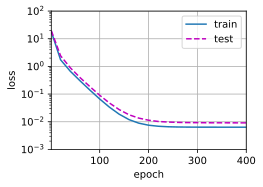

In [21]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight:  [[3.315171  3.7517855]]


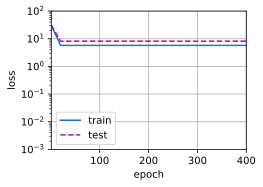

In [22]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight:  [[ 4.9724326   1.2636997  -3.172502    5.2523217  -0.68738073  1.3142322
   0.00892204  0.0792629  -0.05379259 -0.09191676 -0.02493848 -0.00785206
   0.18900266 -0.13391498  0.12052564 -0.20330411 -0.17447284 -0.1931386
  -0.06102229  0.01953216]]


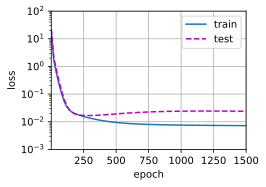

In [23]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)